# Optimization

++++++++++++++++++++++++++++++++++++++++
Total test iteration = 20
Success test         = 20
Failure test         = 0
++++++++++++++++++++++++++++++++++++++++
optimization success:  True
optimal design variable:
   capture_width      11.414 [m]
   pen_diameter       27.362 [m]
   pen_height         27.362 [m]
   stock_density      14.799 [kg/m^3]
   pen number         12.000 [-]
----------------------------------------
deployment Location:
   Longitude       -67.879
   Latitude         43.491
----------------------------------------
optimal objective function terms:
   Objective_func      4.860
   cost per yield     48.604 [Million $ / Tonne]
   NPV               138.869 [Million $]
   fish yield          2.857 [Tonne]
----------------------------------------
optimal wave energy converter:
   wec number          3.567 [-]
   wec_P_ave          76.226 [kW]
   wec AEP        2383419.162 [kWh]
----------------------------------------
optimal price break down:
   wec NPV                  2

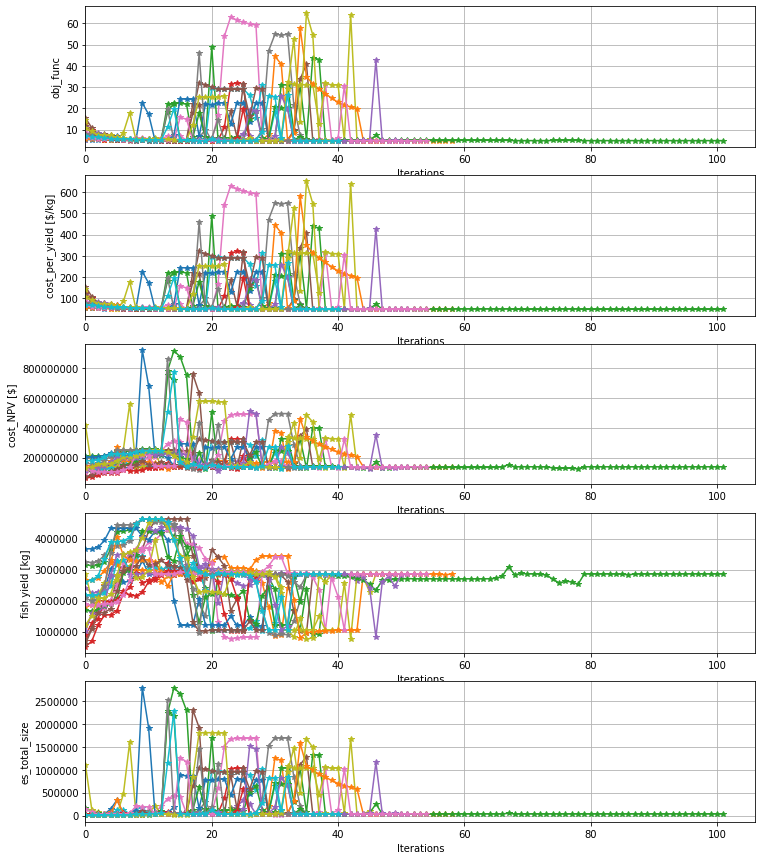

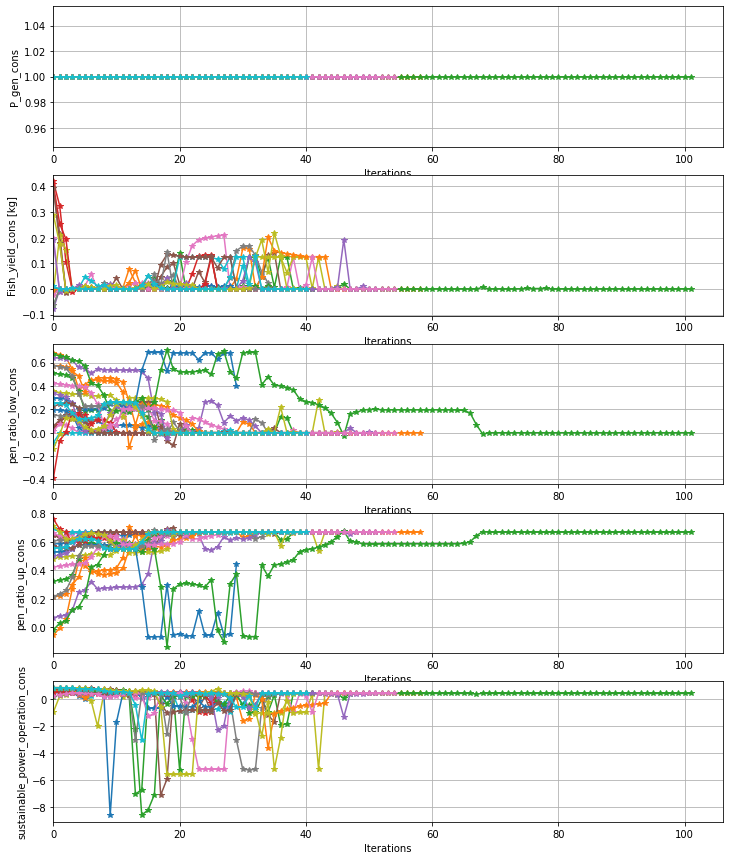

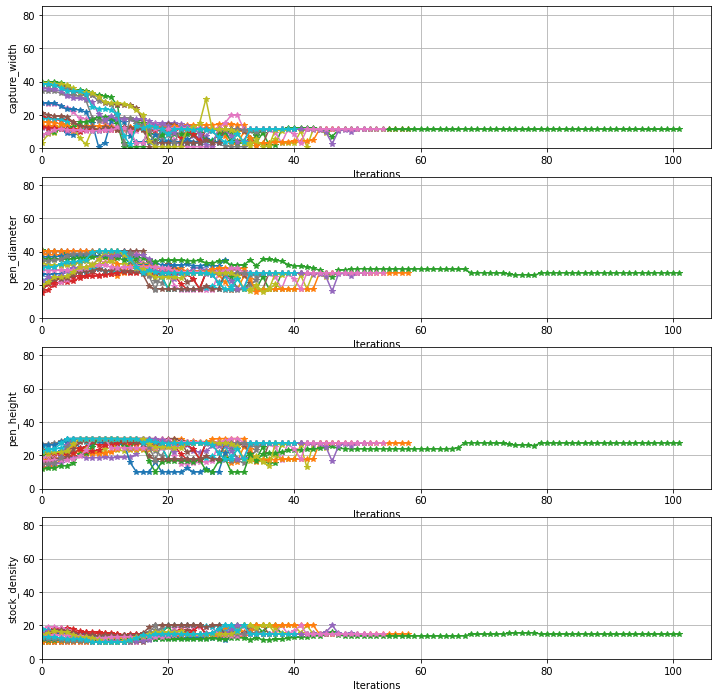

In [1]:
import modules
import optimization
import numpy as np
from wpaf_opt import *
from gis.gis_handler import GISHandler
from matplotlib import pyplot as plt
import pandas as pd
import time
# import importlib
# importlib.reload(modules)
# from matplotlib.ticker import FormatStrFormatter
# from math import pi

test_iter = 20
 
# fill default parameters
all_vars = ['x_wec','x_type_wec','x_pen','p_pen','x_env','p_env','p_wec','p_fish_salmon','pos_env', 'gis_handler', 'p_vessel', 'x_disc_pen', 'p_es', 'p_diesel', 'p_pen_power', 'p_feedbarge']

conditions = {'current [m/s]': 'gis/data/Surface Current (m-s).tif',
              'oxygen [mg/l]': 'gis/data/Surface Oxygen (mg-l).tif',
              'salinity [PSU]': 'gis/data/Surface Salinity (PSU).tif',
              'temperature [°C]': 'gis/data/Surface Temperature (C).tif',
              'period [s]': 'gis/data/Wave Energy Period (s).tif',
              'height [m]': 'gis/data/Wave Significant Height (m).tif',
              'bathymetry [m]': 'gis/data/Bathymetry (m).tif',
              #'distance to shore [m]': 'gis/data/Distance to Shore (m).tif',
              'distance to port [m]': 'gis/data/Distance to Port (m).tif'}

# high fishing is above average, very high is more than one standard deviation above average
conflicts = {'very high fishing traffic': 'gis/data/Very High Fishing Vessel Traffic.geojson',
#            'high fishing traffic': 'data/High Fishing Vessel Traffic.geojson',
             'marine protected areas': 'gis/data/Marine Protected Areas.geojson',
             'danger zones': 'gis/data/Danger Zones and Restricted Areas.geojson',
             'submarine': 'gis/data/Submarine Transit Lanes.geojson',
             'torpex': 'gis/data/Cape Cod TORPEX.geojson',
             'block island': 'gis/data/Block Island Renewable Energy Zone.geojson',
             'ma wind': 'gis/data/MA Wind Energy Areas.geojson',
             'wind lease': 'gis/data/Potential Wind Lease Areas.geojson',
             'wind planning': 'gis/data/Wind Planning Areas.geojson',
             'shipping': 'gis/data/Shipping Lanes.geojson'}

waters = "gis/data/Northeast State and Federal Waters.geojson"

handler = GISHandler(conditions, conflicts, waters)

args = {}
args['handler'] = handler
args['wave_data'] = "../Wave Data/32_43.49_-67.88_2009.csv"
args['aqua_load'] = "../Aquaculture Load/Load 24 hour.xlsx"
args['fixed_num_pen'] = 12


# get the design variable and parameters
x_init, p_init, x, res_opt, p_opt, op_obj = wpaf_opt(all_vars, args)

#history of random iterations
opt_res_history = []
cons_ineq_history = []
#cons_eq_history = []
iteration_history = []
data_history = np.empty([test_iter,len(x.nom0)+2+len(modules.ineq_constraint(x.nom0, x.name, p_opt))]) #design_var + obj + success flag + cons
failed_test_no = 0
failed_test_history = []
res_best=None
p_best=None
x_best=None

#fig for obj func
obj_term_label = ['obj_func','cost_per_yield [$/kg]','cost_NPV [$]', 'fish yield [kg]', 'es_total_size']
obj_terms_no = len(modules.obj_terms(x.nom0, x.name, p_opt))
fig, ax = plt.subplots(obj_terms_no, 1, figsize=(12, obj_terms_no*3))
for i in range (obj_terms_no):
    ax[i] = plt.subplot(obj_terms_no,1,i+1)

#fig for constraints
cons_title = ['P_gen_cons','Fish_yield_cons [kg]','pen_ratio_low_cons', 'pen_ratio_up_cons', 'sustainable_power_operation_cons']
cons_no = len(modules.ineq_constraint(x.nom0, x.name, p_opt))
fig_cons, ax_cons = plt.subplots(cons_no, 1, figsize=(12, cons_no*3))
for i in range (cons_no):
    ax_cons[i] = plt.subplot(cons_no,1,i+1)
#fig for design var
fig_x, ax_x = plt.subplots(len(x.list),1, figsize=(12, 4*3))
for ii in range(len(x.list)):
    ax_x[ii] = plt.subplot(len(x.list),1,ii+1)

#optimization with randomized input
for n_test in range(test_iter):
    x0 = []
    for i0 in range(len(x.bnds)):
        x0.append(np.random.uniform(low=x.bnds[i0][0], high=x.bnds[i0][1]))

    #x0 = [14.217, 27.276,	27.563,	14.783]
    # if n_test ==1:
    #     x0 = [26.69089215022949, 21.68616523194402, 19.058364955056636, 10.386187923256829]

    args['x0'] = x0
    x_init, p_init, x, res_opt, p_opt, op_obj = wpaf_opt(all_vars, args)

    if res_opt.success:
        if ((res_best==None) or (res_opt.fun < res_best.fun)):
            res_best = copy.deepcopy(res_opt)
            p_best = copy.copy(p_opt)
            x_best = copy.deepcopy(x)

        for obj_terms_i in range (obj_terms_no):
            ax[obj_terms_i].plot(op_obj.obj_term_history[:, obj_terms_i], marker='*')      
        for ineq_i in range (cons_no):
            ax_cons[ineq_i].plot(op_obj.ineq[:, ineq_i], marker='*')
        for x_i in range(len(x.list)):
            ax_x[x_i].plot(op_obj.x_history[:, x_i], marker='*')
    else:
        failed_test_history.append(np.array(x0))
        failed_test_no += 1
        
    
    opt_res_history.append(op_obj.f)
    iteration_history.append(op_obj.count)
    cons_ineq_history.append(op_obj.ineq)
    #cons_eq_history.append(op_obj.eq)
    data_history[n_test] = np.concatenate((np.array([res_opt.success]), np.array([res_opt.fun]), np.round(np.array(res_opt.x), decimals = 3), np.array(op_obj.ineq[op_obj.count-1,:])), axis=0)
    
print('+'*40) 
print('Total test iteration =', test_iter)
print('Success test         =', test_iter - failed_test_no)
print('Failure test         =', failed_test_no)
for failed_i in range(failed_test_no):
    print('   ',failed_i, ') failed with:',failed_test_history[failed_i])

#print the optimal result between all random tests
if (res_best!=None):
    print('+'*40) 
    aqua_opt_obj = Aqua_Obj(res_best.x, x_best.name, p_best) 
    optimize_result(aqua_opt_obj, x_best.list, x_best.unit, res_best)

for i in range(obj_terms_no):
    ax[i].set(xlabel='Iterations', ylabel=obj_term_label[i])
    ax[i].grid(True)
    ax[i].set_xlim(0, None)
    ax[i].ticklabel_format(useOffset=False, style='plain', axis='y')
for i in range(cons_no):
    ax_cons[i].set(xlabel='Iterations', ylabel=cons_title[i])
    ax_cons[i].grid(True)
    ax_cons[i].set_xlim(0, None)
    ax_cons[i].ticklabel_format(useOffset=False, style='plain', axis='y')
for i in range(len(x.list)):
    ax_x[i].set(xlabel='Iterations', ylabel=x.list[i])
    ax_x[i].grid(True)
    ax_x[i].set_xlim(0, None)
    ax_x[i].set_ylim(0, 85)
    ax_x[i].ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()

df = pd.DataFrame (data_history)
df = df.set_axis(['success', 'Obj', 'capture_width', 'pen_diameter', 'pen_height', 'stock_density','P_gen_cons','fish_yield_cons_ineq', 'pen_ratio_low_cons', 'pen_ratio_up_cons', 'sustainable_power_operation_cons'], axis=1)
#save data to xlsx format
timestr = time.strftime("%Y%m%d_%H%M%S")
filepath = 'results/design_var_raninit_' + timestr + '.xlsx'
df.to_excel(filepath, index=False)

In [2]:
# ref: https://plotly.com/python/parallel-coordinates-plot/
import plotly.graph_objects as go

df0 = df
#df0['run_id'] = np.random.randn(len(df0))

#remove failure test from figure
df0 = df0.drop(df0[df0['success'] != 1].index)

#Convert values to two decimal points
#df0 = df0.round(2)

alpha = df0.groupby("Obj").size() / df0.shape[0]

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = alpha, # I added this parameter
                   colorscale = [[0,'black'],[1,'black']], # I added this parameter
                   cmin=0, # I added this parameter
                   cmax=1 # I added this parameter
                  ),
        dimensions = list([
            dict(range = [min(df0['capture_width'])-.5,max(df0['capture_width'])+.5],
                #tickvals = np.linspace(min(df0['capture_width'])-.5,max(df0['capture_width'])+.5, 5),
                label = 'Capture Width [m]', values = df0['capture_width']),
            dict(range = [min(df0['pen_diameter'])-.5,max(df0['pen_diameter'])+.5],
                #tickvals = np.linspace(min(df0['pen_diameter'])-.5,max(df0['pen_diameter'])+.5, 5),
                label = 'Pen Diameter [m]', values = df0['pen_diameter']),
            dict(range = [min( df0['pen_height'])-.5,max(df0['pen_height'])+.5],
                #tickvals = np.linspace(min( df0['pen_height'])-.5,max(df0['pen_height'])+.5, 5),
                label = 'Pen Height [m]', values = df0['pen_height']),
            dict(range = [min(df0['stock_density'])-.5,max(df0['stock_density'])+.5],
                #tickvals = np.linspace(min(df0['stock_density'])-.5,max(df0['stock_density'])+.5, 5),
                label = 'Stocking Density [kg/m^3]', values = df0['stock_density']),
            dict(range = [min(df0['Obj'])-.5,max(df0['Obj'])+.5],
                #tickvals = np.linspace(min(df0['Obj'])-.5,max(df0['Obj'])+.5, 5),
                label = 'Cost / Fish Yield [$/kg]', values = df0['Obj']),
            # dict(range = [min(df0['P_gen_cons_ineq'])-.5,max(df0['P_gen_cons_ineq'])+.5],
            #     tickvals = np.linspace(min(df0['P_gen_cons_ineq'])-.5,max(df0['P_gen_cons_ineq'])+.5, 5),
            #     label = 'Norm. Power Supply [-]', values = df0['P_gen_cons_ineq']),
            dict(range = [min(df0['fish_yield_cons_ineq'])-.5,max(df0['fish_yield_cons_ineq'])+.5],
                #tickvals = np.linspace(min(df0['fish_yield_cons_ineq'])-.5,max(df0['fish_yield_cons_ineq'])+.5, 5),
                label = 'Norm. Fish Yield [-]', values = df0['fish_yield_cons_ineq']),
            dict(range = [min(df0['sustainable_power_operation_cons'])-.5,max(df0['sustainable_power_operation_cons'])+.5],
                #tickvals = np.linspace(min(df0['sustainable_power_operation_cons'])-.5,max(df0['sustainable_power_operation_cons'])+.5, 5),
                label = 'Norm. Sust. P [-]', values = df0['sustainable_power_operation_cons'])
        ])
    )
)

fs = 14
fig.update_traces(
    labelfont=
    dict(size= fs), 
    tickfont=dict(size= fs), 
    selector=dict(type='parcoords')
    ) 

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    autosize=False,
    width=1350,
    height=500
    )

fig.write_image("results/Parallel_coordinate.pdf")
fig.write_image("results/Parallel_coordinate.png")
fig.show()

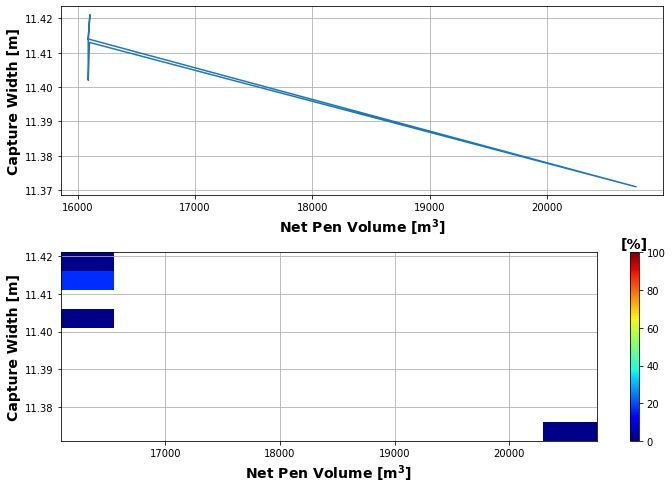

In [3]:
from math import pi
volume = pi * df.pen_height * df.pen_diameter**2 * 0.25

fig, ax = plt.subplots(2,1, figsize=(12, 8))

fs = 14
font = {'weight': 'bold',
        'size': fs} 

ax1 = plt.subplot(211)
plt.xlabel('Net Pen Volume [m$^3$]', fontsize = fs, fontweight = 'bold')
plt.ylabel('Capture Width [m]', fontsize = fs, fontweight = 'bold')
ax1.grid()

ax2 = plt.subplot(212)
my_cmap = plt.cm.jet
my_cmap.set_under('w',1)
hist, xbins, ybins, im = plt.hist2d(volume, df.capture_width, vmin=0, vmax=100, cmin = 1, cmap=my_cmap, bins = 10)

'''
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        print(hist.T[i,j], end =' ')
'''

cbar = plt.colorbar()
cbar.ax.set_xlabel('[%]', fontsize = fs, fontweight = 'bold')
cbar.ax.xaxis.set_label_position('top') 
plt.xlabel('Net Pen Volume [m$^3$]', fontsize = fs, fontweight = 'bold')
plt.ylabel('Capture Width [m]', fontsize = fs, fontweight = 'bold')
ax2.grid()

plt.rc('font', **font)
plt.subplots_adjust(hspace=0.3)

ax1.plot(volume, df.capture_width)
pos1 = ax1.get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0,  pos1.width * .9, pos1.height]
ax1.set_position(pos2) # set a new position
#print('min=',min(volume), min(df.capture_width))
#print('max=',max(volume), max(df.capture_width))


plt.savefig('results/random_init.pdf')
plt.savefig('results/random_init.png')
#plt.show()